In [0]:
import os


In [186]:
!pip install tensorflow-gpu==2.0.0.rc1

In [187]:
!pip install tqdm

In [0]:
import os
import zipfile
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from tqdm import tqdm_notebook
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout


In [0]:
#For ability to mount drive
from google.colab import drive

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [191]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [193]:
#master folder
link = 'https://drive.google.com/open?id=1RiB_SqE4wKkFd7EWygjooF23F6fpkUHs'

fluff, id = link.split('=')
print (id) # Verify that you have everything after '='

1RiB_SqE4wKkFd7EWygjooF23F6fpkUHs


In [0]:
# Finish the pathing to the training, validation, and test directories
dataset_path = "/content/drive/My Drive/mmwml4/"

In [0]:
train_dir = os.path.join(dataset_path, "train")
validation_dir = os.path.join(dataset_path, "val")
test_dir = os.path.join(dataset_path, "test")

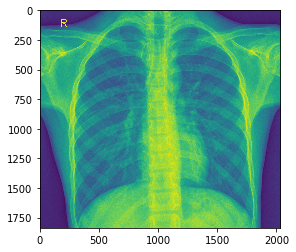

In [196]:
example_img = mpimg.imread(test_dir + "/NORMAL/IM-0005-0001.jpeg")
plt.imshow(example_img)

In [0]:
def plot_img(subset, category, labeled = False, sample_size = 6):
  
  full_path = dataset_path + subset + '/' + category
  
  # Check if sample_size is valid
  if (sample_size > len([file for file in os.listdir(full_path)])):
      print(len([file for file in os.listdir('.') if os.path.isfile(file)]))
      print("Not enough files in ", full_path)
      return
    
  # Define the figure size
  plt.figure(figsize=(18, 12))
  
  for i, file in enumerate(os.listdir(full_path)):

    # Check if number of images to display has been reached
    if(i >= sample_size):
      break
    img = mpimg.imread(full_path + '/' + file)
    plt.subplot(231 + i)

    if labeled:
      plt.title(file.split('-')[1])
    
    plt.imshow(img)

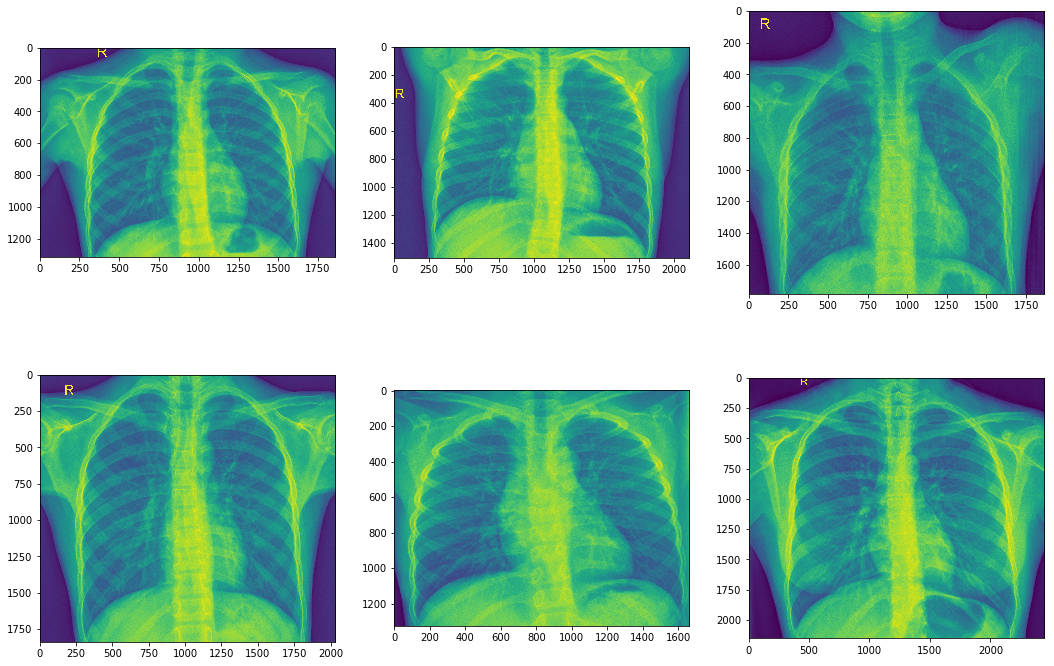

In [198]:
plot_img("test", "NORMAL")

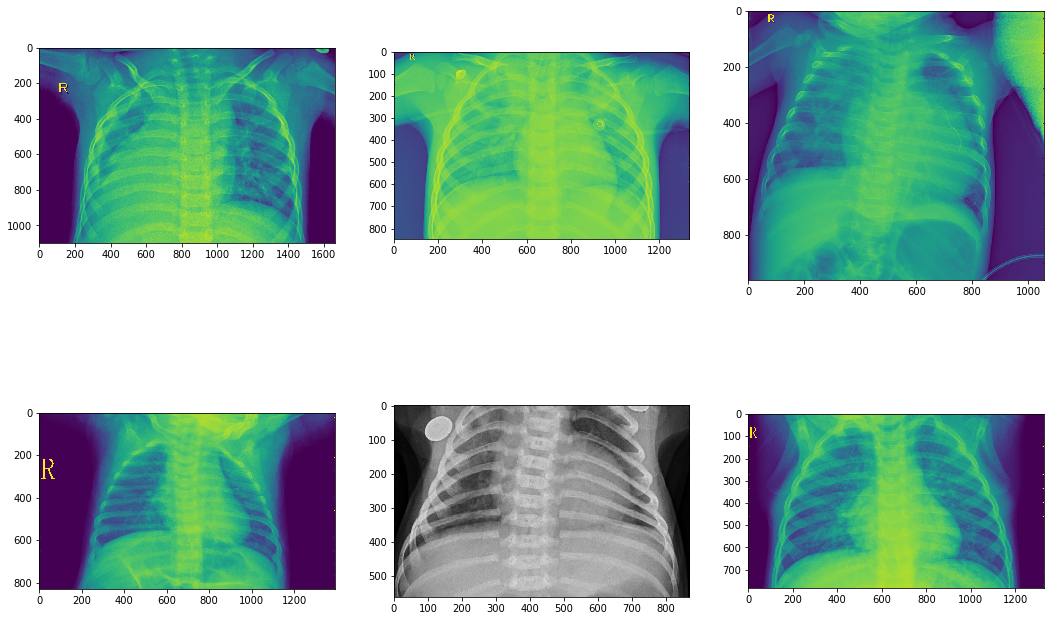

In [199]:
plot_img("train", "PNEUMONIA")

In [0]:
def compare_img(subset, labeled = False):
  path = dataset_path + subset
  
  # Taking a random sample from both the PNEUMONIA and the NORMAL directory
  random_pneumonia = np.random.choice(os.listdir(path + "/PNEUMONIA"))
  random_normal = np.random.choice(os.listdir(path + "/NORMAL"))
  
  # Figure size
  fig=plt.figure(figsize=(16, 16))


  # Displaying images
  a = fig.add_subplot(1, 2, 1)
  normal = mpimg.imread(path + "/NORMAL/" + random_normal)
  image1 = plt.imshow(normal)
  
  
  # Option to show the label 
  if labeled:
    a.set_title('NORMAL')
    
  a = fig.add_subplot(1, 2, 2)
  pneumonia = mpimg.imread(path + "/PNEUMONIA/" + random_pneumonia)
  image2 = plt.imshow(pneumonia)
  
  # Option to show the label 
  if labeled:
    a.set_title('PNEUMONIA')
  

  plt.show()

In [202]:
compare_img("train", labeled = True)

FileNotFoundError: ignored

Building the Model

In [0]:
IMG_SHAPE = (150, 150, 3)

In [0]:
base_model = tf.keras.applications.InceptionV3(input_shape = IMG_SHAPE, include_top = False, weights="imagenet")

In [224]:
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_188 (Conv2D)             (None, 74, 74, 32)   864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_188 (BatchN (None, 74, 74, 32)   96          conv2d_188[0][0]                 
__________________________________________________________________________________________________
activation_188 (Activation)     (None, 74, 74, 32)   0           batch_normalization_188[0][0]    
_______________________________________________________________________________________

In [226]:
base_model.output

<tf.Tensor 'mixed10_2/Identity:0' shape=(None, 3, 3, 2048) dtype=float32>

In [0]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)

In [229]:
global_average_layer

<tf.Tensor 'global_average_pooling2d_5/Identity:0' shape=(None, 2048) dtype=float32>

In [0]:
global_average_layer = Dense(512, activation='relu')(global_average_layer)
global_average_layer = Dropout(0.3)(global_average_layer)
global_average_layer = Dense(256, activation='relu')(global_average_layer)
global_average_layer = Dropout(0.3)(global_average_layer)
global_average_layer = Dense(128, activation='relu')(global_average_layer)
global_average_layer = Dropout(0.3)(global_average_layer)
prediction_layer = tf.keras.layers.Dense(units=2, activation='sigmoid')(global_average_layer)

Define the Model

In [0]:
model = tf.keras.models.Model(inputs=base_model.input, outputs=prediction_layer)

In [232]:

model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_188 (Conv2D)             (None, 74, 74, 32)   864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_188 (BatchN (None, 74, 74, 32)   96          conv2d_188[0][0]                 
__________________________________________________________________________________________________
activation_188 (Activation)     (None, 74, 74, 32)   0           batch_normalization_188[0][0]    
____________________________________________________________________________________________

Compiling

In [0]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.0001), loss="sparse_categorical_crossentropy", metrics=["accuracy"])

Data Generators

In [0]:
data_gen_train = ImageDataGenerator(rescale=1/255.)
data_gen_valid = ImageDataGenerator(rescale=1/255.)

In [239]:

train_generator = data_gen_train.flow_from_directory(train_dir, target_size=(150,150), batch_size=32, class_mode="categorical")

Found 1037 images belonging to 1 classes.


In [240]:
valid_generator = data_gen_valid.flow_from_directory(validation_dir, target_size=(150,150), batch_size=32, class_mode="categorical")

Found 16 images belonging to 2 classes.


In [241]:
test_generator = data_gen_valid.flow_from_directory(test_dir, target_size=(150,150), batch_size=32, class_mode="categorical")

Found 624 images belonging to 2 classes.


Training the Model

In [242]:
model.fit_generator(train_generator, epochs = 3, validation_data = valid_generator)

Epoch 1/3
32/33 [============================>.] - ETA: 9s - loss: 0.0217 - accuracy: 1.0000 

ValueError: ignored

Model Evaluation

In [0]:
valid_loss, valid_accuracy = model.evaluate_generator(valid_generator)

In [0]:
print("Accuracy after the transfer learning: {}".format(valid_accuracy))

NameError: ignored

Plotting our Results

In [0]:
def compare_results(root_path, generator):
  
  predictions = model.predict_generator(generator)
  class_predicted= [np.argmax(prediction) for prediction in predictions]
  fig = plt.figure(figsize=(24,18))
  fig.subplots_adjust(hspace=1.5)
  
  normal_path = root_path + '/NORMAL/'
  pneumonia_path = root_path + '/PNEUMONIA/'
  
  normal_dir = os.listdir(normal_path)
  pneumonia_dir = os.listdir(pneumonia_path)
  
  normal_gen = (x for x in normal_dir if x.endsiwth('.jpeg'))
  pneumonia_gen = (y for y in pneumonia_dir if y.endswith('.jpeg'))
  
  for i, normal_file in enumerate(normal_gen):
    img = plt.imread(normal_path + normal_file)
    plt.subplot( 4, 4, 1 + i)
    plt.title(f"Prediction: NORMAL\nTrue value: NORMAL" if class_predicted[i] == 1 
              else f"Prediction: PNEUMONIA\nTrue value: NORMAL")
    plt.imshow(img)
    
  for j, pneumonia_file in enumerate(pneumonia_gen):
    img = plt.imread(pneumonia_path + pneumonia_file)
    plt.subplot(4, 4, 9 + j)
    plt.title(f"Prediction: NORMAL\nTrue value: PNEUMONIA" if class_predicted[8+j] == 1 
              else f"Prediction: PNEUMONIA\nTrue value: PNEUMONIA")
    plt.imshow(img)

Saving our Model

In [0]:
import json
model_json = model.to_json()
with open("architecture.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("model.h5")
print("Saved model to disk")

In [0]:
Additional Fine Tuning

In [0]:
base_model.trainable = True

In [0]:
print("Number of layers in the base model: {}".format(len(base_model.layers)))

In [0]:
fine_tune_at = 200

In [0]:
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

In [0]:
model.compile(optimzer=tf.keras.optimizers.RMSprop(lr=0.0001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [0]:
model.fit_generator(generator = train_generator, epochs = 5, validation_data = valid_generator)

Evaluating our Fine Tuning

In [0]:
valid_loss, valid_accuracy = model.evaluate_generator(valid_generator)

In [0]:
print("Validation accuracy after fine tuning: {}".format(valid_accuracy))

In [0]:
compare_results(validation_dir, valid_generator)